# Spectral Diffusion for a Toy ${\rm SU}(2)$ Model using Group-Valued Score Matching

In this notebook, we apply the same machinery we used in the other notebook (where we trained a score network to learn the heat kernel and denoise the variance-expanding diffusion process) to learn a toy theory involving a single ${\rm SU}(2)$ matrix $U$ (one independent eigenangle $\theta$).

## Setup

In [1]:
import math
import torch
import numpy as np

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import sun_diffusion
import sun_diffusion.analysis as al  # analysis library

from sun_diffusion.action import SUNToyPolynomialAction
from sun_diffusion.sun import (
    mat_angle, adjoint,
    extract_diag, embed_diag,
    random_sun_element, random_un_haar_element,
)
from sun_diffusion.diffusion import VarianceExpandingDiffusionSUN, PowerDiffusionSUN
from sun_diffusion.heat import sun_score_hk
from sun_diffusion.utils import grab, compute_ess, compute_kl_div

In [3]:
from sun_diffusion.devices import get_device, get_dtype, set_device, summary
set_device('cuda', 0)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float32


## Define a Target Theory and Generate Training Data

The target theory whose distribution we will try to reproduce is specified by a toy action of our choosing, which we define to be 
$$S_i(U) = -\frac{\beta}{2} {\rm Re}{\rm Tr}\left[\sum_n c_n U^n\right].$$

In [4]:
Nc = 2
beta = 1.0
coeffs_dict = {
    0: [1.0, 0., 0.],
    1: [0.17, -0.65, 1.22],
    2: [0.98, -0.63, -0.21]
}  # from Table I of [2008.05456]

coeffs = 1  # change this to try other coefficient sets
action = SUNToyPolynomialAction(beta, coeffs_dict[coeffs])

To generate configurations, we will use the Metropolis algorithm for simplicity.

In [5]:
def apply_metropolis(batch_size, Nc, action, num_therm, num_iters, step_size, save_freq=10):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    U = random_sun_element(batch_size, Nc=Nc)
    ens = []
    for i in tqdm.tqdm(range(-num_therm, num_iters)):
        # Proposal
        V = random_sun_element(batch_size, Nc=Nc, scale=step_size)
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand(batch_size)  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))
        if i >= 0 and (i+1) % save_freq == 0:
            ens.append(U)
    return torch.cat(ens), action_vals, accept_rates

In [6]:
# Generate samples
batch_size = 32
num_therm = 1_000
num_iters = 10_240
save_freq = 10
step_size = 0.9

num_train = batch_size * (num_iters // save_freq)
print(f'{num_train=}')

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = batch_size,
    Nc = Nc,
    action = action,
    num_therm = num_therm,
    num_iters = num_iters,
    step_size = step_size
)
print('U_train shape:', U_train.shape)

num_train=32768


  0%|          | 0/11240 [00:00<?, ?it/s]

U_train shape: torch.Size([32768, 2, 2])


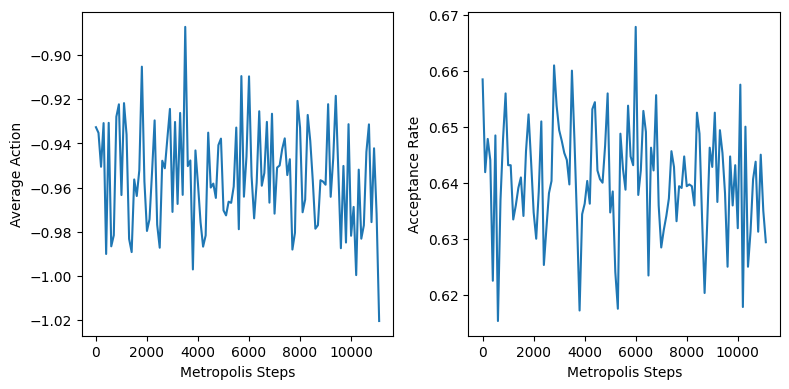

In [7]:
# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(*al.bin_data(action_vals, binsize=100))
axes[0].set_ylabel('Average Action')

axes[1].plot(*al.bin_data(accept_rates, binsize=100))
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
plt.show()

ps shape: torch.Size([101])


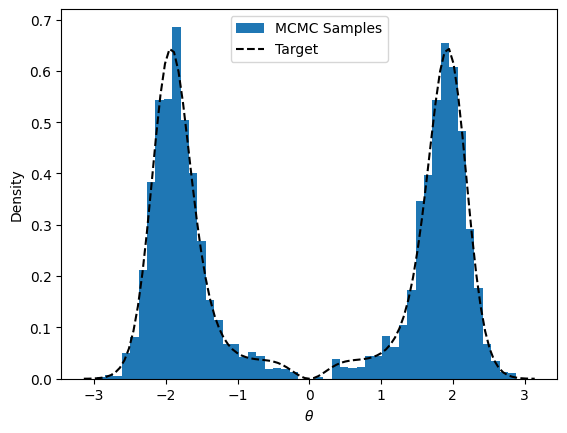

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(grab(mat_angle(U_train[::10])[0][:, 0]), bins=50, density=True, label='MCMC Samples')
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = ths[1] - ths[0]
ths = torch.stack([ths, -ths], dim=-1)
ps = torch.exp(-action.value_eigs(ths)) * torch.sin(ths[:, 0])**2
ps /= torch.sum(ps * dth, dim=-1, keepdims=True)
print('ps shape:', ps.shape)
ax.plot(grab(ths[:, 0]), grab(ps), color='k', linestyle='--', label='Target')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Density')

ax.legend()
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

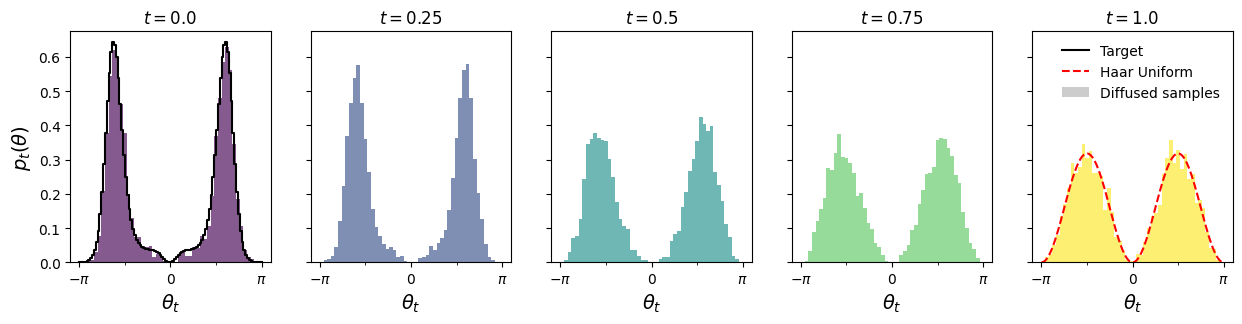

In [9]:
kappa = 3.0
# diffuser = VarianceExpandingDiffusionSUN(kappa)
diffuser = PowerDiffusionSUN(kappa, alpha=1)

times = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 3), sharey=True)
axes[0].set_ylabel(r'$p_t(\theta)$', fontsize=14)

bins = np.linspace(-np.pi, np.pi, num=51)

U_0 = U_train.clone()[::10]
for t, ax in zip(times, axes):
    if t == 0:  # avoid sampling from HK at t=0
        x_t, _, _ = mat_angle(U_0)
    else:
        U_t, _, _ = diffuser.diffuse(U_0, t*torch.ones(U_0.size(0)), n_iter=15)
        x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=bins, density=True, color=cmap(t), alpha=0.65)
    ax.set_xlabel(r'$\theta_t$', fontsize=14)
    ax.set_title(f'$t = {t}$')
    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels([r"$-\pi$", r"$0$", r"$\pi$"])
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([-np.pi/2, np.pi/2]))
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)

# also save histograms for future comparisons
true_times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.10, 0.05, 0.01]
true_hists = []
for t in tqdm.tqdm(true_times):
    hist_xt = np.zeros(len(bins)-1, dtype=np.float64)
    for chunk_U in torch.chunk(U_0, 10):
        U_t, _, _ = diffuser.diffuse(chunk_U, t*torch.ones(chunk_U.size(0)), n_iter=15)
        x_t, _, _ = mat_angle(U_t)
        hist_xt += np.histogram(grab(x_t[:, 0]), bins=bins)[0]
    hist_xt /= U_0.size(0) * (bins[1]-bins[0])
    true_hists.append((bins, hist_xt))

# Target density
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = grab(ths[1]-ths[0])
ths = torch.stack([ths, -ths], dim=-1)
ps = grab((-action.value_eigs(ths)).exp()) * np.sin(grab(ths[:,0]))**2
ps /= np.sum(ps, axis=-1, keepdims=True) * dth
target_line, = axes[0].step(grab(ths[:, 0]), ps, color='k', label='Target')

# Haar uniform
xs = torch.linspace(-np.pi, np.pi, 100)
haar = (1 / np.pi) * torch.sin(xs)**2
haar_line, = axes[-1].plot(grab(xs), grab(haar), ls='--', color='red', label='Haar Uniform')

sample_patch = mpl.patches.Patch(facecolor='gray', alpha=0.4, label='Diffused samples')
axes[-1].legend(
    handles=[target_line, haar_line, sample_patch],
    loc='upper right',
    frameon=False
)

plt.show()

## Train a Score Network

Now we must construct a score network that will take as input the eigenangle $\theta$ and time $t$.

In [10]:
class SU2ScoreNet(torch.nn.Module):
    def __init__(self, input_dim=3, hidden_dim=8):
        super().__init__()
        assert input_dim % 2 == 1
        self.nk = (input_dim - 1)//2
        self.net = torch.nn.Sequential(
            # input_dim = 1 eigenangle + encoded time
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 1))
        
    def forward(self, x_t, t):
        assert len(x_t.shape) == 2, \
            'input eigenangles shape should be [batch_size, Nc-1]'
        assert len(t.shape) == 1, \
            'times should only have a batch dimension'
        cos_t = torch.cos(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        sin_t = torch.sin(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        inp = torch.cat([x_t, cos_t, sin_t], dim=-1)
        return self.net(inp) * torch.sin(x_t) # enforce score -> 0 at endpoints


def _test_su2_score_net():
    batch_size = 10
    Nc = 2
    x = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    t = torch.rand((batch_size,))
    s_t = SU2ScoreNet()(x, t)

    assert s_t.shape == x.shape, \
        '[FAILED: score net output must have same shape as input data]'
    print('[PASSED]')

_test_su2_score_net()

[PASSED]


Define the loss functions

In [11]:
def score_matching_loss_sun(U_0, diffuser, score_net, tol=1e-4):
    batch_size = U_0.size(0)
    t = tol + (1 - tol) * torch.rand(batch_size)
    sigma_t = diffuser.sigma_func(t)

    U_t, xs, V = diffuser.diffuse(U_0, t, n_iter=25)
    x_t, P, Pinv = mat_angle(U_t)

    score = score_net(x_t[..., :-1], t)
    # NOTE(gkanwar): Passing xs instead of (x_t - x_0) is important here
    true_score_xs = sun_score_hk(xs[..., :-1], width=sigma_t)
    true_score = extract_diag(Pinv @ V @ embed_diag(true_score_xs).to(V) @ adjoint(V) @ P).real[...,:-1]

    # NOTE(gkanwar): Scaling by sigma_t^2 results in a roughly constant variance,
    # making training much more stable.
    diff = score - true_score
    loss = torch.mean(sigma_t[:, None]**2 * diff**2)
    return loss

Do the training

In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Make diffusion process
kappa = 3.0
alpha = 1.0
diffuser = PowerDiffusionSUN(kappa, alpha)
#diffuser = VarianceExpandingDiffusionSUN(kappa)

score_net = SU2ScoreNet(input_dim=51, hidden_dim=64)

# Setup training hyperparams
epochs = 200
lr = 1e-3
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Prepare dataloader
batch_size = 1024
dataset = TensorDataset(U_train) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=get_device()))

# Training loop
losses = []
score_net.train()
for epoch in tqdm.tqdm(range(epochs)):
    total_loss = 0.0
    for batch_idx, (U_0_batch,) in enumerate(tqdm.tqdm(dataloader, leave=False)):
        optimizer.zero_grad()
        loss = score_matching_loss_sun(U_0_batch, diffuser, score_net)
        loss.backward()
        optimizer.step()
        total_loss += grab(loss)
        losses.append(grab(loss))
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch}/{epochs} | Loss = {avg_loss:.6f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0/200 | Loss = 0.304751


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/200 | Loss = 0.304553


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/200 | Loss = 0.298512


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/200 | Loss = 0.297945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/200 | Loss = 0.299042


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/200 | Loss = 0.305283


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/200 | Loss = 0.301913


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/200 | Loss = 0.299424


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/200 | Loss = 0.294489


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/200 | Loss = 0.298301


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200 | Loss = 0.292184


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/200 | Loss = 0.299418


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/200 | Loss = 0.291122


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/200 | Loss = 0.287947


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/200 | Loss = 0.291707


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/200 | Loss = 0.288842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/200 | Loss = 0.289371


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/200 | Loss = 0.287538


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/200 | Loss = 0.287494


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/200 | Loss = 0.284093


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200 | Loss = 0.286176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/200 | Loss = 0.286380


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/200 | Loss = 0.287532


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/200 | Loss = 0.281251


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/200 | Loss = 0.290144


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/200 | Loss = 0.288082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/200 | Loss = 0.293193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/200 | Loss = 0.284647


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/200 | Loss = 0.285289


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/200 | Loss = 0.281095


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200 | Loss = 0.285637


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/200 | Loss = 0.286306


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/200 | Loss = 0.280685


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/200 | Loss = 0.287887


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/200 | Loss = 0.287394


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/200 | Loss = 0.285466


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/200 | Loss = 0.285194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/200 | Loss = 0.283502


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/200 | Loss = 0.287643


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/200 | Loss = 0.288868


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200 | Loss = 0.282609


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/200 | Loss = 0.281094


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/200 | Loss = 0.285931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/200 | Loss = 0.282459


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/200 | Loss = 0.282575


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/200 | Loss = 0.280433


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/200 | Loss = 0.278376


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/200 | Loss = 0.280587


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/200 | Loss = 0.279762


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/200 | Loss = 0.286869


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200 | Loss = 0.287325


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51/200 | Loss = 0.282980


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52/200 | Loss = 0.282454


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53/200 | Loss = 0.284417


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54/200 | Loss = 0.279903


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55/200 | Loss = 0.283762


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56/200 | Loss = 0.284211


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57/200 | Loss = 0.289954


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58/200 | Loss = 0.280499


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59/200 | Loss = 0.282238


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200 | Loss = 0.292822


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 61/200 | Loss = 0.279163


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62/200 | Loss = 0.280089


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63/200 | Loss = 0.281986


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64/200 | Loss = 0.284763


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65/200 | Loss = 0.285698


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66/200 | Loss = 0.279596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67/200 | Loss = 0.285270


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68/200 | Loss = 0.282442


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69/200 | Loss = 0.282038


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200 | Loss = 0.280962


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71/200 | Loss = 0.283918


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72/200 | Loss = 0.282159


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73/200 | Loss = 0.288074


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74/200 | Loss = 0.285493


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75/200 | Loss = 0.279717


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76/200 | Loss = 0.284668


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77/200 | Loss = 0.283760


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78/200 | Loss = 0.285525


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79/200 | Loss = 0.284562


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200 | Loss = 0.283746


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 81/200 | Loss = 0.285264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 82/200 | Loss = 0.282063


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 83/200 | Loss = 0.285472


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 84/200 | Loss = 0.285524


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 85/200 | Loss = 0.282330


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 86/200 | Loss = 0.279522


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 87/200 | Loss = 0.284081


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 88/200 | Loss = 0.284483


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 89/200 | Loss = 0.280381


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200 | Loss = 0.284326


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 91/200 | Loss = 0.283480


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 92/200 | Loss = 0.279755


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 93/200 | Loss = 0.278362


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 94/200 | Loss = 0.283504


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 95/200 | Loss = 0.285941


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 96/200 | Loss = 0.281073


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 97/200 | Loss = 0.279264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 98/200 | Loss = 0.282537


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 99/200 | Loss = 0.288112


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200 | Loss = 0.282107


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 101/200 | Loss = 0.280550


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 102/200 | Loss = 0.279484


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 103/200 | Loss = 0.282032


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 104/200 | Loss = 0.276037


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 105/200 | Loss = 0.283563


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 106/200 | Loss = 0.279332


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 107/200 | Loss = 0.280102


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 108/200 | Loss = 0.287415


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 109/200 | Loss = 0.281671


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200 | Loss = 0.280780


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 111/200 | Loss = 0.279169


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 112/200 | Loss = 0.286733


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 113/200 | Loss = 0.279784


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 114/200 | Loss = 0.278913


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 115/200 | Loss = 0.278861


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 116/200 | Loss = 0.281480


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 117/200 | Loss = 0.282329


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 118/200 | Loss = 0.284721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 119/200 | Loss = 0.283728


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200 | Loss = 0.283163


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 121/200 | Loss = 0.283968


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 122/200 | Loss = 0.283330


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 123/200 | Loss = 0.282073


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 124/200 | Loss = 0.281559


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 125/200 | Loss = 0.286295


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 126/200 | Loss = 0.282585


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 127/200 | Loss = 0.282171


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 128/200 | Loss = 0.280247


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 129/200 | Loss = 0.281040


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200 | Loss = 0.277381


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 131/200 | Loss = 0.283235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 132/200 | Loss = 0.279502


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 133/200 | Loss = 0.280793


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 134/200 | Loss = 0.285836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 135/200 | Loss = 0.285633


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 136/200 | Loss = 0.282605


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 137/200 | Loss = 0.279237


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 138/200 | Loss = 0.283252


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 139/200 | Loss = 0.281618


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200 | Loss = 0.281215


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 141/200 | Loss = 0.279841


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 142/200 | Loss = 0.281245


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 143/200 | Loss = 0.281200


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 144/200 | Loss = 0.281036


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 145/200 | Loss = 0.281055


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 146/200 | Loss = 0.281871


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 147/200 | Loss = 0.284097


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 148/200 | Loss = 0.275388


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 149/200 | Loss = 0.283428


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200 | Loss = 0.285962


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 151/200 | Loss = 0.279442


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 152/200 | Loss = 0.285030


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 153/200 | Loss = 0.285246


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 154/200 | Loss = 0.278827


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 155/200 | Loss = 0.280300


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 156/200 | Loss = 0.281171


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 157/200 | Loss = 0.280109


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 158/200 | Loss = 0.279275


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 159/200 | Loss = 0.282297


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200 | Loss = 0.280638


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 161/200 | Loss = 0.287140


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 162/200 | Loss = 0.285770


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 163/200 | Loss = 0.278970


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 164/200 | Loss = 0.283425


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 165/200 | Loss = 0.279400


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 166/200 | Loss = 0.281651


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 167/200 | Loss = 0.281059


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 168/200 | Loss = 0.280478


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 169/200 | Loss = 0.276399


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200 | Loss = 0.279374


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 171/200 | Loss = 0.283131


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 172/200 | Loss = 0.280706


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 173/200 | Loss = 0.283047


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 174/200 | Loss = 0.277456


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 175/200 | Loss = 0.282690


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 176/200 | Loss = 0.281743


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 177/200 | Loss = 0.284678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 178/200 | Loss = 0.282422


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 179/200 | Loss = 0.279668


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200 | Loss = 0.284470


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 181/200 | Loss = 0.282205


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 182/200 | Loss = 0.281782


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 183/200 | Loss = 0.279968


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 184/200 | Loss = 0.283289


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 185/200 | Loss = 0.281749


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 186/200 | Loss = 0.282329


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 187/200 | Loss = 0.279638


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 188/200 | Loss = 0.282571


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 189/200 | Loss = 0.278285


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200 | Loss = 0.282316


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 191/200 | Loss = 0.278401


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 192/200 | Loss = 0.280281


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 193/200 | Loss = 0.285436


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 194/200 | Loss = 0.279860


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 195/200 | Loss = 0.281656


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 196/200 | Loss = 0.283767


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 197/200 | Loss = 0.280446


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 198/200 | Loss = 0.280339


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 199/200 | Loss = 0.278095


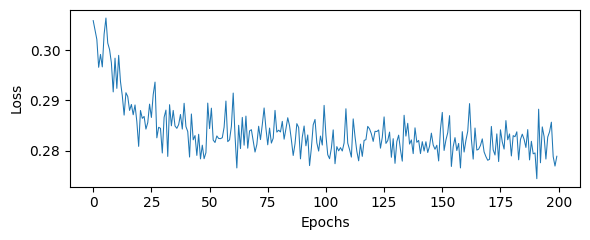

In [14]:
# Plot training loss vs epochs
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
xs, ys = al.bin_data(losses, binsize=25)
xs = xs / (num_train/batch_size) # convert to epochs
ax.plot(xs, ys, lw=0.75)
fig.set_tight_layout(True)
plt.show()

Compare the learned score function to the force for the target theory:

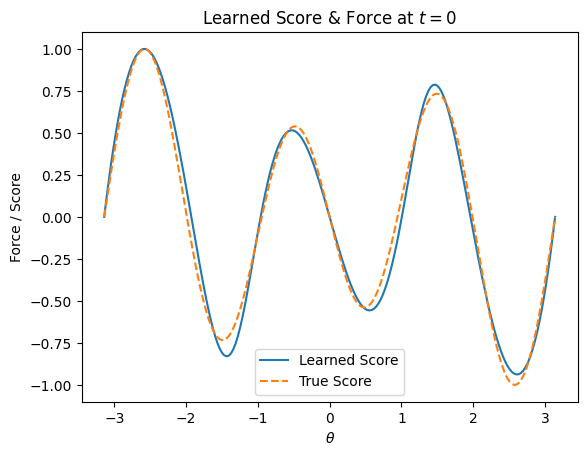

In [15]:
xs_eval = torch.linspace(-np.pi, np.pi, 200)

learned_score = score_net(xs_eval.unsqueeze(-1), torch.zeros(len(xs_eval))) 
learned_score /= learned_score.abs().max()

true_score = action.force_eigs(xs_eval)
true_score /= true_score.abs().max()

plt.plot(grab(xs_eval), grab(learned_score), label='Learned Score')
plt.plot(grab(xs_eval), grab(true_score), '--', label='True Score')
plt.xlabel(r'$\theta$')
plt.ylabel('Force / Score')
plt.title('Learned Score & Force at $t=0$')
plt.legend()
plt.show()


## Denoising Process

Now we run the reverse process to generate new samples.

In [16]:
def sample_sun_gaussian(shape):
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))

In [17]:
@torch.no_grad()
def solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=False):
    trajectories = {
        'U_t': [],
        'logp': [],
        'logq': [],
        'kl_div': [],
        'ess': [],
        't': [],
        'Z': [],
    }
    dt = 1 / num_steps
    t = 1.0
    batch_size = U_1.size(0)
    x_1, V, V_inv = mat_angle(U_1)
    x_t = x_1.clone()

    logJ = 0.
    for step in tqdm.tqdm(range(num_steps)):
        # Get ODE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((batch_size,)))
        jac = torch.func.vmap(torch.func.jacfwd(lambda x: score_net(x[None], torch.tensor(t)[None])[0]))(x_t[..., :-1])
        div = torch.einsum('...ii->...', jac)
        
        # Integration step in reverse time
        score = torch.cat([score, -score.sum(-1, keepdim=True)], dim=-1)
        x_t = x_t + 0.5 * g_t**2 * score * dt
        logJ = logJ + 0.5 * g_t**2 * div * dt

        # Eigen-recomposition
        D = embed_diag(torch.exp(1j * x_t)).to(V)
        U_t = V @ D @ V_inv
        t -= dt

        # Collect and print metrics
        logp = -action(U_t) + log_haar_su2(x_t)
        logq = logr - logJ
        Z = al.bootstrap(grab((logp - logq).exp()), Nboot=1000, f=al.rmean)
        kl_div = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_kl_div)
        ess = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_ess)
        if verbose and step % 20 == 0:
            print(f'Step {step}/{num_steps}')
            print('logp =', logp.mean().item())
            print('logq =', logq.mean().item())
            print('Dkl =', kl_div)
            print('ESS =', ess)
            print()
        trajectories['t'].append(t)
        trajectories['U_t'].append(grab(U_t))
        trajectories['logp'].append(al.bootstrap(grab(logp), Nboot=1000, f=al.rmean))
        trajectories['logq'].append(al.bootstrap(grab(logq), Nboot=1000, f=al.rmean))
        trajectories['kl_div'].append(kl_div)
        trajectories['ess'].append(ess)
        trajectories['Z'].append(Z)

    for key in ['Z', 'kl_div', 'ess', 'logp', 'logq']:
        trajectories[key] = np.stack(trajectories[key], axis=1)
    
    return U_t, logJ, trajectories

In [18]:
def log_haar_su2(x):
    """Computes log likelihood of SU(2) Haar uniform density."""
    x = x[:, 0]
    log_sin2 = 2*torch.log(torch.abs(torch.sin(x)))
    log_norm = math.log(np.pi)
    return log_sin2 - log_norm

In [19]:
#num_samples = batch_size
num_samples = 4096
Nc = 2
U_1 = random_un_haar_element(num_samples, Nc=Nc)
U_1 *= (torch.linalg.det(U_1)**(-1/Nc) * torch.exp(2j*np.pi*torch.randint(Nc, size=(num_samples,))/Nc))[...,None,None]

In [20]:
# Get prior log likelihood
x_1, _, _ = mat_angle(U_1)
logr = log_haar_su2(x_1)
print('avg logr =', logr.mean().item())
print('std logr =', logr.std().item())

avg logr = -1.525813102722168
std logr = 0.5395377278327942


In [21]:
U_0, logJ, history = solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=True)
x_0, _, _ = mat_angle(U_0)

  0%|          | 0/200 [00:00<?, ?it/s]

Step 0/200
logp = -1.2016559839248657
logq = -1.525644063949585
Dkl = (-0.3241661, 0.013682719)
ESS = (0.637174807083007, 0.004266234796713611)

Step 20/200
logp = -1.17661714553833
logq = -1.5234663486480713
Dkl = (-0.3466986, 0.0128378505)
ESS = (0.6538765923389922, 0.004192035500378336)

Step 40/200
logp = -1.137590765953064
logq = -1.5140502452850342
Dkl = (-0.37609875, 0.01293014)
ESS = (0.6769231583289855, 0.004041535473782039)

Step 60/200
logp = -1.0794625282287598
logq = -1.4929488897323608
Dkl = (-0.4129861, 0.012271174)
ESS = (0.7081267973830764, 0.00388994708237627)

Step 80/200
logp = -0.9936718940734863
logq = -1.4550708532333374
Dkl = (-0.46185106, 0.010940856)
ESS = (0.7505957781892623, 0.0033547142177760263)

Step 100/200
logp = -0.8710696697235107
logq = -1.3983116149902344
Dkl = (-0.5268267, 0.008858871)
ESS = (0.8139956978014269, 0.0027346612564901106)

Step 120/200
logp = -0.723006010055542
logq = -1.321138620376587
Dkl = (-0.59841734, 0.0061916783)
ESS = (0.895660

/tmp/ipykernel_1330576/1792919208.py:24: RuntimeWarning: invalid value encountered in divide
  p /= np.sum(p)*grab(xs[1,0]-xs[0,0])


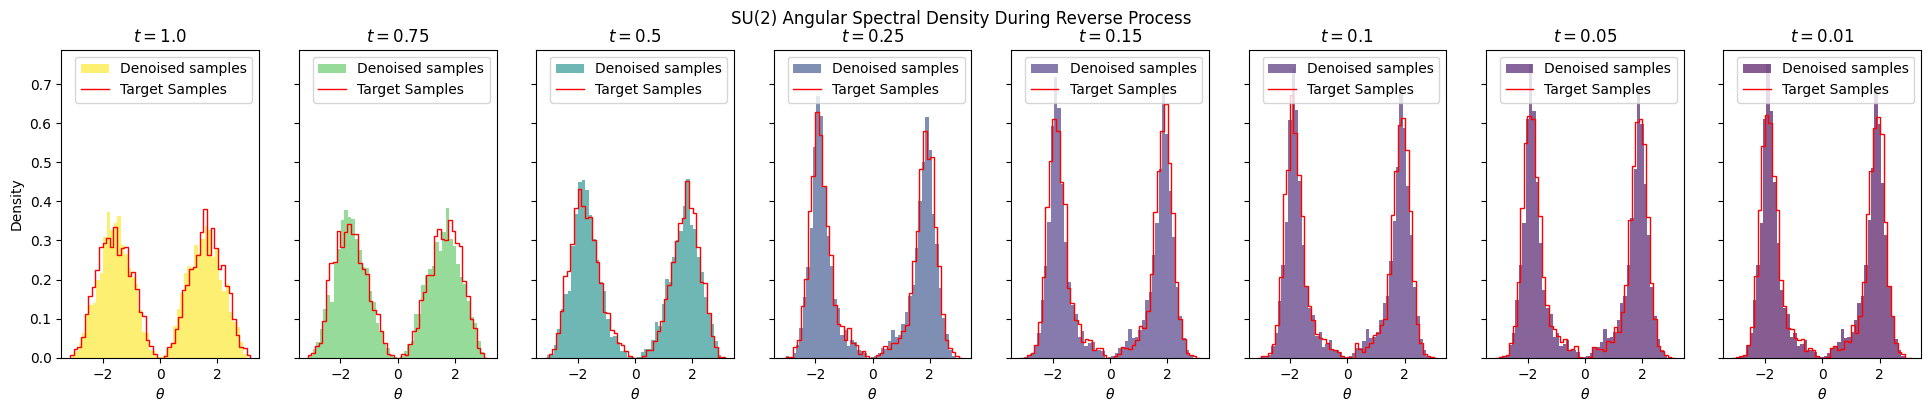

In [22]:
# Plot reverse trajectories
# times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.01]
times = true_times
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 4), sharey=True)
fig.suptitle('SU(2) Angular Spectral Density During Reverse Process')
axes[0].set_ylabel('Density')
xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
for t, hist, ax in zip(times, true_hists, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(history['U_t']))
    U_t = torch.tensor(history['U_t'][step])
    x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')
    
    # Forward diffused samples
    ax.stairs(hist[1], hist[0], ec='red', color='none', label='Target Samples')
    
    # integrate score to get model distribution
    sigma_t = max(0.1, diffuser.sigma_func(t))
    bx = score_net(xs, t*torch.ones((xs.size(0),)))[...,0] / sigma_t**2
    logp_hat = torch.cumsum(bx, dim=-1) * (xs[1,0]-xs[0,0])
    p = grab((logp_hat + log_haar_su2(xs)).exp())
    p /= np.sum(p)*grab(xs[1,0]-xs[0,0])

    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
plt.show()

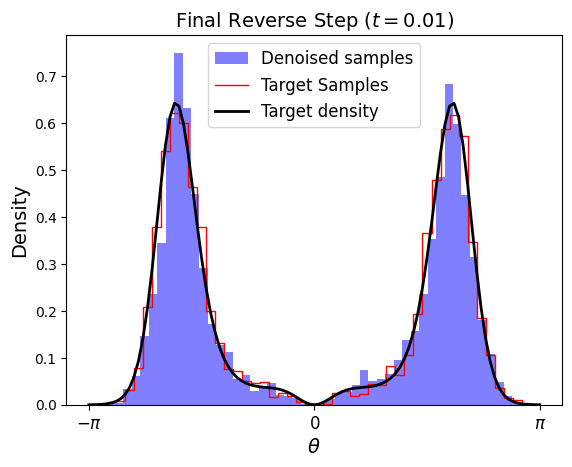

In [23]:
fig, ax = plt.subplots(1, 1)
t = times[-1]
hist = true_hists[-1]

# Histogram denoised samples
step = int((1 - t) * len(history['U_t']))
U_t = torch.tensor(history['U_t'][step])
x_t, _, _ = mat_angle(U_t)

ax.hist(grab(x_t[:, 0]), bins=50, density=True, color='blue', alpha=0.5, label='Denoised samples')
ax.stairs(hist[1], hist[0], ec='red', color='none', label='Target Samples')

# Analytical target density
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = grab(ths[1]-ths[0])
ths_stack = torch.stack([ths, -ths], dim=-1)
ps = grab((-action.value_eigs(ths_stack)).exp()) * np.sin(grab(ths))**2
ps /= np.sum(ps, axis=-1, keepdims=True) * dth
ax.plot(grab(ths), ps, color='black', lw=2, label='Target density')

# Format
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r"$-\pi$", r"$0$", r"$\pi$"], fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.legend(fontsize=12)

# Plot
ax.set_title(rf'Final Reverse Step ($t={t}$)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlabel(r'$\theta$', fontsize=14)
plt.show()

In [24]:
def _measure_Z():
    th = torch.linspace(-np.pi, np.pi, steps=501)
    x = torch.stack([th, -th], axis=-1)
    U = embed_diag((1j*x).exp())
    est_Z = grab((th[1]-th[0])*(-action(U) + log_haar_su2(x)).exp().sum())
    return est_Z
true_Z = _measure_Z()

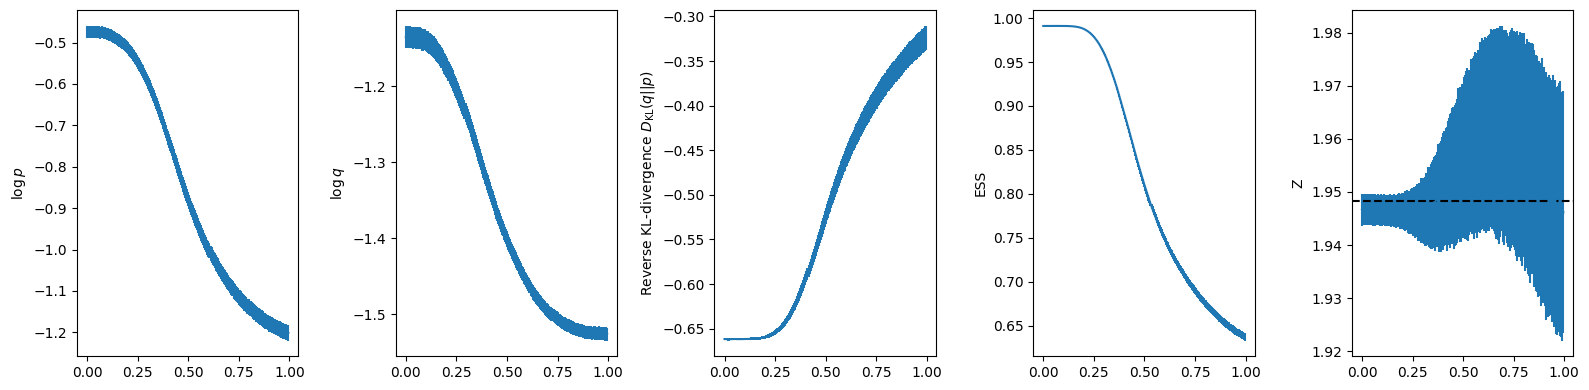

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].errorbar(history['t'], history['logp'][0], yerr=history['logp'][1])
axes[0].set_ylabel(r'$\log p$')

axes[1].errorbar(history['t'], history['logq'][0], yerr=history['logq'][1])
axes[1].set_ylabel(r'$\log q$')

axes[2].errorbar(history['t'], history['kl_div'][0], yerr=history['kl_div'][1])
axes[2].set_ylabel(r'Reverse KL-divergence $D_{\rm KL}(q || p)$')

axes[3].errorbar(history['t'], history['ess'][0], yerr=history['ess'][1])
axes[3].set_ylabel('ESS')

axes[4].errorbar(history['t'], history['Z'][0], yerr=history['Z'][1])
axes[4].axhline(true_Z, color='k', linestyle='--')
axes[4].set_ylabel('Z')

fig.tight_layout()
plt.show()

In [26]:
# Model likelihood
logq = logr - logJ
print('avg logq =', logq.mean().item())
print('std logq =', logq.std().item())

avg logq = -1.135834813117981
std logq = 0.8842672109603882


In [27]:
# Target likelihood
logp = -action(U_0) + log_haar_su2(x_0)
print('avg logp =', logp.mean().item())
print('std logp =', logp.std().item())

avg logp = -0.47419247031211853
std logp = 0.909933865070343


In [28]:
# Effective Sample Size
print('ESS =', compute_ess(logp, logq))

ESS = 0.9911265858848135
